# Lab4.5 Emotional classification with Llama3

Copyright: Vrije Universiteit Amsterdam, Faculty of Humanities, CLTL

Through this notebook, you will annotate a text with Llama version 3, a Generative Large Language Model model released by [Meta](https://llama.meta.com/llama3/). 

You will read a conversation and send the utterances to the Llama server to annotate each using instructions, soca-lled prompting. For running a server locally see the notebook **how-to-install-llama-server.ipynb* from the start of the course. Note that the server needs to run in another terminally in parallel to this notebook. In case you cannot run the server, use the credentials for the CLTL server.

The code for the annotator is given in **llama_annotator.py**. It is an OpenAI client that sends a prompt request to a llama server server for a response.

### Installation of an OpenAI client

To run the annotator, you first need to install the OpenAI client using the following command line. If you ran the code for Llama Chat client you already did this.

In [9]:
#! pip install openai

Once succesfully installed, you can comment out the previous cell and you do not need to do this again when running this notebook. The OpenAI module is now installed on your machine and can be imported. The import will be done by the **llama_annotator.py** script, which we will load next.

## Creating the Llama chatbot

In [1]:
from llama_annotator import LlamaAnnotator

If there are no error messages, we can create a chatbot instance of a LlamaAnnotator as defined in **llama_annotator.py**. We define **annotator** as an instance of a LLamaCAnnotator, where we can specify three additional parameters: the *url* of the server (either local or online), the labels that we want to use for the annoation and optionally examples of the input and output.

In [6]:
### Labels to try
sentiment_labels = ["positive", "negative", "neutral"]
ekman_labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]
examples = [{"Input": "I love dogs", "Output": "joy"}, {"Input": "I hate cats", "Output": "disgust"}]
cltl_url = "http://130.37.53.128:9001/v1"
local_url = "http://localhost:9001/v1"
#annotator = LlamaAnnotator(url=cltl_url, labels=ekman_labels, examples=examples)
annotator = LlamaAnnotator(url=local_url, labels=ekman_labels, examples=examples)

My instructions are: [{'role': 'system', 'content': 'You are an intelligent assistant.'}, {'role': 'system', 'content': 'You will receive utterances from a conversation as Input in JSON format.'}, {'role': 'system', 'content': "You need to decide whether one of the following labels apply:['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']"}, {'role': 'system', 'content': 'Output the most appropriate label in JSON format.'}, {'role': 'system', 'content': 'Do not output anything else.'}, {'role': 'system', 'content': 'Here are a few examples:'}, {'role': 'user', 'content': 'I love dogs'}, {'role': 'system', 'content': 'joy'}, {'role': 'user', 'content': 'I hate cats'}, {'role': 'system', 'content': 'disgust'}]


We are now going to read the conversation that we had before with Llama with our annotations and send these to the server again to annotate.

In [7]:
import pandas as pd

annotation_file = "/Users/piek/Desktop/t-MA-HLT-introduction-2024/ma-hlt-labs-class/lab0.llama/other/adjudicated_annotations.json"
annotation_file = "/Users/piek/Downloads/specific_utterances.json"

df = pd.read_json(annotation_file)
df.head()

,utterance,speaker,turn_id,Annotator,Gold,Votes,Annotators,Adjudication
2,I hope that your dried llama food isn't anythi...,Raul,8,Pawel,disgust,"[disgust, disgust, neutral]","[Pawel, Leo Mylonadis, Matt]",disgust
8,I am not beefed just upset by many things. Wea...,Robert,8,Pawel,anger,"[anger, sadness, sadness]","[Pawel, Leo Mylonadis, Matt]",sadness
11,"Well,when it's coming to life abnd lemons I wo...",Robert,14,Pawel,neutral,"[neutral, sadness, anger]","[Pawel, Leo Mylonadis, Matt]",neutral
30,Can you please stop acting as if you're happy ...,"Hi, my name is Anna.",10,Pawel,anger,"[anger, neutral, anger, neutral, anger, joy]","[Pawel, Pawel, Leo Mylonadis, Leo Mylonadis, L...",anger
142,I will go for some beer with my friends! Can't...,Carol,26,Urtė,joy,"[joy, joy, joy]","[Urtė, Aidona Katsanaki Menares, Martha]",joy


From the Pandas dataframe, we can select the "utterance" column as the list of utterances and give this to the ```anotate``` funciton that is defined for our LlamaAnotator. We store the output in the annotations list.

In [8]:
utterances = df["utterance"]
subset = 100
annotations = annotator.annotate(utterances[:subset])
print(annotations[:10])

Processed 10 turns out of 20
Processed 20 turns out of 20
[{'Input': "I hope that your dried llama food isn't anything illicit! ", 'Output': 'surprise'}, {'Input': 'I am not beefed just upset by many things. Weather was just a beginning.', 'Output': 'anger'}, {'Input': "Well,when it's coming to life abnd lemons I would rather mnix gin and tonic. Especially after such a morning.   ", 'Output': 'surprise'}, {'Input': "Can you please stop acting as if you're happy and interested. That is super annoying!", 'Output': 'anger'}, {'Input': "I will go for some beer with my friends! Can't wait!", 'Output': 'joy'}, {'Input': "To be honest, my trip is a bit rushed. My friends dropped out last minute, so I have to go for a solo-trip this time. I'm so annoyed and frustrated with that!", 'Output': 'sadness'}, {'Input': "I believe I can try. I'm just so disgusted with my friends' behaviour!", 'Output': 'disgust'}, {'Input': "The problem is that with friends we planned to do camping, but now I have to 

We can add the predictions from Llama to the dataframe but Llama does not always precisely follow the instructions e.g. "Output: Output:neutral". We therefore need to clean and filter the output. Specifically, we check if any of the Ekman labels is a substring of the Llama output and then take that value. If none of these is matched, we set the value to None.

In [7]:
test_labels = df['Adjudication'][:subset]

predictions = []
for anno in annotations:
    if 'Output' in anno:
        prediction = anno['Output']
    else:
        prediction = "None"
    llama_label = "None"
    for label in test_labels:
        if label in prediction:
            llama_label = label
    predictions.append(llama_label)
print(predictions)

['neutral', 'None', 'fear', 'None', 'surprise', 'surprise', 'None', 'None', 'fear', 'neutral', 'sadness', 'fear', 'fear', 'fear', 'sadness', 'joy', 'fear', 'surprise', 'surprise', 'surprise', 'fear', 'joy', 'joy', 'fear', 'neutral', 'neutral', 'joy', 'fear', 'fear', 'fear', 'fear', 'fear', 'fear', 'sadness', 'fear', 'sadness', 'sadness', 'fear', 'sadness', 'sadness', 'fear', 'fear', 'fear', 'sadness', 'sadness', 'sadness', 'fear', 'fear', 'fear', 'fear', 'sadness', 'anger', 'neutral', 'neutral', 'fear', 'None', 'sadness', 'sadness', 'sadness', 'None', 'sadness', 'None', 'None', 'None', 'sadness', 'sadness', 'sadness', 'None', 'None', 'sadness', 'None', 'None', 'None', 'anger', 'sadness', 'None', 'None', 'joy', 'sadness', 'anger', 'anger', 'None', 'joy', 'None', 'None', 'sadness', 'sadness', 'None', 'neutral', 'joy', 'joy', 'sadness', 'neutral', 'neutral', 'fear', 'fear', 'fear', 'disgust', 'sadness', 'neutral']


Note that Llama may not follow the instructions correctly despite the instructions. It may ignore the JSON format, make up new labels or do other "creative" things being triggered by the input text. Always check the output carefully. If Llama does not generate the right output, we can consider this as an error. In this case, it generates "Output:sadness" as a label in one case.

In [8]:
### We pair the test_labels and the predictions
for pair in zip(test_labels,predictions):
    print(pair)

labels = list(test_labels)+list(predictions)
label_set = sorted(set(labels))
print(label_set)

('neutral', 'neutral')
('neutral', 'None')
('anger', 'fear')
('surprise', 'None')
('fear', 'surprise')
('fear', 'surprise')
('joy', 'None')
('neutral', 'None')
('disgust', 'fear')
('joy', 'neutral')
('sadness', 'sadness')
('sadness', 'fear')
('fear', 'fear')
('surprise', 'fear')
('disgust', 'sadness')
('joy', 'joy')
('anger', 'fear')
('joy', 'surprise')
('joy', 'surprise')
('surprise', 'surprise')
('joy', 'fear')
('joy', 'joy')
('surprise', 'joy')
('disgust', 'fear')
('joy', 'neutral')
('neutral', 'neutral')
('joy', 'joy')
('fear', 'fear')
('anger', 'fear')
('fear', 'fear')
('disgust', 'fear')
('neutral', 'fear')
('fear', 'fear')
('sadness', 'sadness')
('anger', 'fear')
('sadness', 'sadness')
('anger', 'sadness')
('fear', 'fear')
('anger', 'sadness')
('joy', 'sadness')
('fear', 'fear')
('fear', 'fear')
('surprise', 'fear')
('sadness', 'sadness')
('joy', 'sadness')
('neutral', 'sadness')
('fear', 'fear')
('neutral', 'fear')
('joy', 'fear')
('disgust', 'fear')
('sadness', 'sadness')
('jo

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

report = classification_report(test_labels,predictions ,digits = 7, target_names=label_set)
print('Llama Ekman ----------------------------------------------------------------')

print(report)

Llama Ekman ----------------------------------------------------------------
              precision    recall  f1-score   support

        None  0.0000000 0.0000000 0.0000000         0
       anger  0.7500000 0.1666667 0.2727273        18
     disgust  0.0000000 0.0000000 0.0000000         7
        fear  0.2962963 0.6666667 0.4102564        12
         joy  0.7500000 0.3333333 0.4615385        18
     neutral  0.5000000 0.2173913 0.3030303        23
     sadness  0.4400000 0.7333333 0.5500000        15
    surprise  0.2000000 0.1428571 0.1666667         7

    accuracy                      0.3400000       100
   macro avg  0.3670370 0.2825311 0.2705274       100
weighted avg  0.5005556 0.3400000 0.3452622       100



/Users/piek/Desktop/t-MA-HLT-introduction-2024/ma-hlt-labs-class/venv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piek/Desktop/t-MA-HLT-introduction-2024/ma-hlt-labs-class/venv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piek/Desktop/t-MA-HLT-introduction-2024/ma-hlt-labs-class/venv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` pa

We can see that the results are not very good, which we could have guessed from the paired list of values: "joy" is never assigned and "sadness" is assigned when it should not. Think about how to improve the prompt to make it better. 

Confusion matrix SVM
[[ 0  0  0  0  0  0  0  0]
 [ 2  3  1  7  0  0  5  0]
 [ 0  0  0  5  0  1  1  0]
 [ 0  0  0  8  0  2  0  2]
 [ 3  1  0  2  6  2  2  2]
 [11  0  0  2  0  5  5  0]
 [ 2  0  0  1  1  0 11  0]
 [ 2  0  0  2  1  0  1  1]]


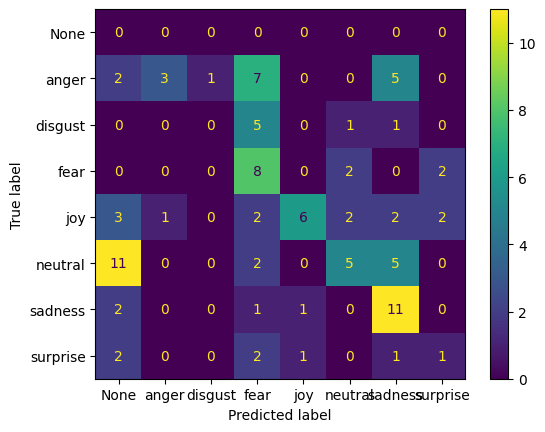

In [10]:
print('Confusion matrix SVM')
cf_matrix = confusion_matrix(test_labels,predictions)
print(cf_matrix)
display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label_set)
display.plot()

## End of notebook

In [9]:
len(annotations)

20

In [10]:
print(annotations)

[{'Input': "I hope that your dried llama food isn't anything illicit! ", 'Output': 'surprise'}, {'Input': 'I am not beefed just upset by many things. Weather was just a beginning.', 'Output': 'anger'}, {'Input': "Well,when it's coming to life abnd lemons I would rather mnix gin and tonic. Especially after such a morning.   ", 'Output': 'surprise'}, {'Input': "Can you please stop acting as if you're happy and interested. That is super annoying!", 'Output': 'anger'}, {'Input': "I will go for some beer with my friends! Can't wait!", 'Output': 'joy'}, {'Input': "To be honest, my trip is a bit rushed. My friends dropped out last minute, so I have to go for a solo-trip this time. I'm so annoyed and frustrated with that!", 'Output': 'sadness'}, {'Input': "I believe I can try. I'm just so disgusted with my friends' behaviour!", 'Output': 'disgust'}, {'Input': "The problem is that with friends we planned to do camping, but now I have to book hotels last minute! It will cost me a fortune! It's s

In [12]:
import json
filename = "sample_annotation_llama.json"
with open(filename,'w') as file:
    json.dump(annotations, file, indent = 4)